In [138]:
import numpy as np
import random
import math
from scipy import stats
from tqdm import tqdm
import string
import pandas as pd
import importlib
import sys
from ast import literal_eval
from multiprocessing import Pool
from os.path import join
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
PROJ_DIR = '/home/gcgreen2/alignment'
GIT_DIR = join(PROJ_DIR,'SequenceAlignmentAndSketching')

sys.path.append(GIT_DIR)
import suffix_hash as sh

In [143]:
sys.path.append(join(GIT_DIR,'utils'))
import seq_utils as su
# from utils import aln_utils as au
# from utils import metric_utils as mu

In [141]:
importlib.reload(su)

NameError: name 'su' is not defined

In [190]:
def get_matching_bases(i, j, seq1, seq2):
    count = 0
    while(i<len(seq1) and j<len(seq2) and seq1[i]==seq2[j]):
        count += 1
        i += 1
        j += 1
    return count

def est_overlap(sketch1, sketch2, seq1, seq2):
    n_matching_bases = [get_matching_bases(i,j,seq1,seq2) for i,j in zip(sketch1, sketch2)]
    total_match = sum(n_matching_bases)
    return n_matching_bases

def edit_dist(s, t, d=5):
    if len(s)!=len(t): return -1
    rows = len(s)+1
    deletes, inserts, substitutes = (1,1,1)
    
    dist = [[np.inf for _ in range(2*d+3)] for i in range(rows)]

    # source prefixes can be transformed into empty strings 
    # by deletions:
    for row in range(d+1):
        dist[row][d-row+1] = row * deletes

    # target prefixes can be created from an empty source string
    # by inserting the characters
    for col in range(d+1):
        dist[0][col+d+1] = col * inserts 
        
    # dynamic programming
    for row in range(1, rows):
        for col in range(max(-d,-row+1),min(d+1,rows-row)):
            cost = 0 if s[row-1] == t[row+col-1] else substitutes
            dist[row][col+d+1] = min(dist[row-1][col+d+2] + deletes,
                                 dist[row][col+d] + inserts,
                                 dist[row-1][col+d+1] + cost) # substitution
        if min(dist[row]) > d: return -1
    
    return min(dist[-1])

# def iterative_levenshtein(s, t, costs=(1, 1, 1)):
#     rows = len(s)+1
#     cols = len(t)+1
#     deletes, inserts, substitutes = costs
    
#     dist = [[0 for x in range(cols)] for x in range(rows)]

#     # source prefixes can be transformed into empty strings 
#     # by deletions:
#     for row in range(1, rows):
#         dist[row][0] = row * deletes

#     # target prefixes can be created from an empty source string
#     # by inserting the characters
#     for col in range(1, cols):
#         dist[0][col] = col * inserts
        
#     for col in range(1, cols):
#         for row in range(1, rows):
#             if s[row-1] == t[col-1]:
#                 cost = 0
#             else:
#                 cost = substitutes
#             dist[row][col] = min(dist[row-1][col] + deletes,
#                                  dist[row][col-1] + inserts,
#                                  dist[row-1][col-1] + cost) # substitution
 
#     return dist[row][col]

def est_overlap(sketch1, sketch2, seq1, seq2, k=50):
    edit_dists = [edit_dist(seq1[i:i+k],seq2[j:j+k]) for i,j in zip(sketch1, sketch2)]
    return sum([e for e in edit_dists if e<15])

def pairwise_overlap_ests(sketches, seqs, seq_lens):
    pairwise_ests = []
    n = len(seq_lens)
    for i in tqdm(range(n), desc='Estimating pairwise overlaps', leave=True):
        for j in range(n):
            if i==j: continue
            theta_hat = est_overlap(sketches[i], sketches[j], seqs[i], seqs[j])
            pairwise_ests.append((i+1,j+1,theta_hat,seq_lens[i],seq_lens[j]))
    return pairwise_ests


In [174]:
dset = 'gc0.2_sub1.68_ins8.04_del3.16'
reads_path = join(GIT_DIR, 'data', dset, 'reads.fasta')

In [192]:
n=100
seqs = su.get_seqs(reads_path)[:n]; seq_lens = [len(s) for s in seqs]
sketches = sh.get_all_sketches(seqs, 100, max(seq_lens))

In [193]:
estimates = pairwise_overlap_ests(sketches, seqs, seq_lens)

Estimating pairwise overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:54<00:00,  1.74s/it]


In [189]:
estimates[:10]

[(1, 2, 71, 14635, 15201),
 (1, 3, 82, 14635, 11534),
 (1, 4, 55, 14635, 17315),
 (1, 5, 46, 14635, 8995),
 (1, 6, 27, 14635, 8560),
 (1, 7, 13, 14635, 10492),
 (1, 8, 0, 14635, 7184),
 (1, 9, 0, 14635, 14669),
 (1, 10, 0, 14635, 9501),
 (1, 11, 0, 14635, 13600)]

(array([254.,  28.,  26.,  10.,  26.,  12.,  14.,   4.,   4.,   2.]),
 array([  0. ,  23.2,  46.4,  69.6,  92.8, 116. , 139.2, 162.4, 185.6,
        208.8, 232. ]),
 <BarContainer object of 10 artists>)

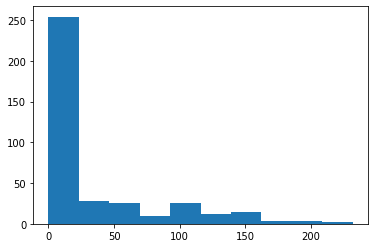

In [129]:
plt.hist([est[2] for est in estimates])

### True overlap vs. edit distance

In [130]:
pred_df = pd.DataFrame(estimates, columns=['i1','i2','overlap','l1','l2'])

In [131]:
pred_df.head()

,i1,i2,overlap,l1,l2
0,1,2,160,14635,15201
1,1,3,144,14635,11534
2,1,4,66,14635,17315
3,1,5,52,14635,8995
4,1,6,96,14635,8560


In [132]:
gt_path = join(GIT_DIR, 'data', dset, 'ground_truth.txt')
gt_df = pd.read_csv(gt_path, sep='\t', header=None, names=['i1','i2','overlap','l1','l2'])
gt_df = gt_df.query(f'i1 <= {n} and i2 <= {n}')

In [133]:
overlaps = mu.get_overlaps(pred_df, gt_df)

Text(0, 0.5, 'Predicted Alignment Size')

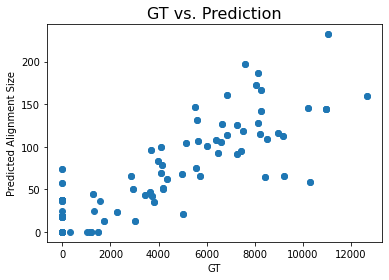

In [134]:
plt.plot(overlaps[:,0],overlaps[:,1],'o')
# plt.plot([0,overlaps[:,1].max()], [0,overlaps[:,1].max()], '--', color='red')
plt.title('GT vs. Prediction',fontsize=16)
plt.xlabel('GT')
plt.ylabel('Predicted Alignment Size')

## Fit normal curve

In [33]:
from scipy.optimize import minimize
from scipy.stats import norm
from numpy.random import normal

In [98]:
def normal_pdf_first_half(mu,sigma,size=10000):
    xs = normal(mu, sigma, size=size)
    xs = [int(x) for x in xs if x<=mu and x>-0.5]
    xs, ys = np.unique(xs, return_counts=True)
    ys = ys/sum(ys)
    return xs, ys

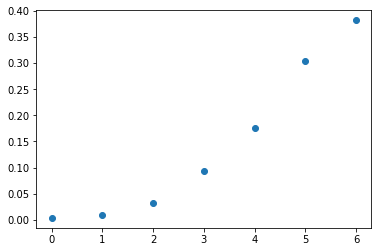

In [99]:
xs,ys = normal_pdf_first_half(7,2)
plt.plot(xs,ys,'o')

In [100]:
log_ys = np.log(ys)

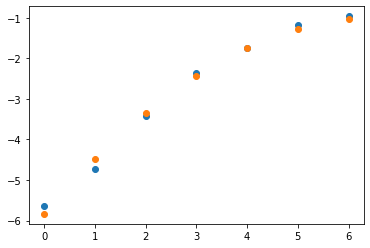

In [105]:
mu,sigma,offset = [6.63407468, 2.12926149, 2.        ]
plt.plot(xs,log_ys,'o')
# plt.plot(xs,[-1/2*np.log(2*np.pi*sigma**2)-1/(2*sigma**2)*(x-mu)**2+np.log(2) for x in xs], 'o')
plt.plot(xs,[np.log(norm.pdf(x,loc=mu,scale=sigma))+np.log(offset) for x,log_y in zip(xs,log_ys)], 'o')

In [102]:
mse=lambda mu,sigma,offset,x,log_y: (np.log(norm.pdf(x,loc=mu,scale=sigma))+np.log(offset)-log_y)**2
def func(x):
    mu,sigma,offset = x
    return np.sum(
        [(np.log(norm.pdf(x,loc=mu,scale=sigma))+np.log(offset)-log_y)**2 \
            for x,log_y in zip(xs,log_ys)])

In [109]:
minimize(func, x0=(7,2,2), bounds=[(2,15),(0.1,10),(0.5,3)]).x

array([7.2904093 , 2.29608091, 2.74455996])

In [107]:
func([6.63407468, 2.12926149, 2.        ])

0.1293013564220741

## other thresholding for top matching 

In [122]:
PROJ_DIR = '/home/gcgreen2/alignment'
GITDIR = join(PROJ_DIR, 'SequenceAlignmentAndSketching')
DATASETS = 'gc0.2  gc0.2_del3.16  gc0.2_ins8.04  gc0.2_ins8.04_del3.16  gc0.2_sub1.68  gc0.2_sub1.68_ins8.04_del3.16  nctc1080'
DATASETS = DATASETS.split()
dset = 'gc0.2_sub1.68_ins8.04_del3.16'
gt_path = lambda dset: join(GITDIR, 'data', dset, 'ground_truth.txt')
fasta_path = lambda dset: join(GITDIR, 'data', dset, 'reads.fasta')
ALN_DIR = join(PROJ_DIR, 'out','5-17-sh-1-thresh')
pred_path = lambda dset: join(ALN_DIR, dset+'_aln.tsv')

In [123]:
pred_df = pd.read_csv(pred_path(dset), sep='\t', header=None, names=['i1','i2','overlap','l1','l2', 'arr'])

In [124]:
gt_df = pd.read_csv(gt_path(dset), sep='\t', header=None, names=['i1','i2','overlap','l1','l2'])


In [125]:
pred_df.head(2)

,i1,i2,overlap,l1,l2,arr
0,1,2,535,14635,15201,"[8, 5, 7, 6, 5, 7, 6, 7, 5, 7, 6, 7, 6, 5, 6, ..."
1,1,3,581,14635,11534,"[6, 5, 7, 6, 6, 7, 5, 9, 5, 9, 7, 8, 6, 6, 6, ..."


In [126]:
gt_df.head(2)

,i1,i2,overlap,l1,l2
0,1,2,12668,13925,14480
1,1,3,10991,13925,10991


In [127]:
gt_tuples = set([tuple(i) for i in gt_df[['i1','i2']].values])

In [128]:
err_idx = [i for i,j in tqdm(enumerate(pred_df[['i1','i2']].values), leave=True, position=0) if tuple(j) not in gt_tuples]
correct_idx = [i for i,j in tqdm(enumerate(pred_df[['i1','i2']].values), leave=True, position=0) if tuple(j) in gt_tuples]

502309it [00:00, 699657.50it/s]
502309it [00:00, 789516.21it/s]


In [129]:
all_vals = [literal_eval(arr) for arr in tqdm(pred_df.arr.values, leave=True, position=0)]


0it [68:58:37, ?it/s]                                         | 2545/502309 [00:02<06:34, 1265.87it/s]
100%|████████████████████████████████████████████████████████| 502309/502309 [09:16<00:00, 902.52it/s]


In [130]:
vals = np.concatenate(all_vals)

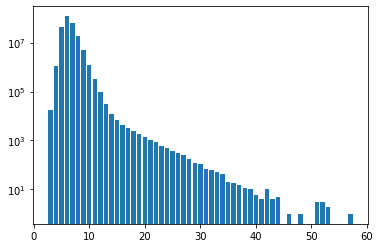

In [131]:
unique_vals, counts = np.unique(vals, return_counts=True)
plt.bar(unique_vals,counts)
plt.yscale('log')

<BarContainer object of 46 artists>

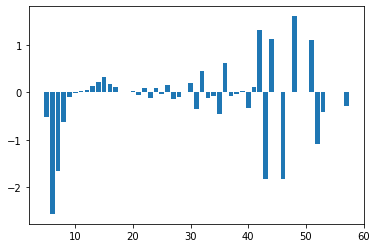

In [135]:
inflec = [np.log(counts[i])-np.log(counts[i-1]) for i in range(1,len(counts))]
inflec = [inflec[i]-inflec[i-1] for i in range(1,len(inflec))]
plt.bar(unique_vals[2:], inflec)

In [137]:
inflec_pts = [unique_vals[i+3] for i in range(1,len(inflec)) if np.sign(inflec[i])!=np.sign(inflec[i-1])][0]
inflec_pts

12

In [40]:
err_vals = np.concatenate([all_vals[i] for i in err_idx])
correct_vals = np.concatenate([all_vals[i] for i in correct_idx])

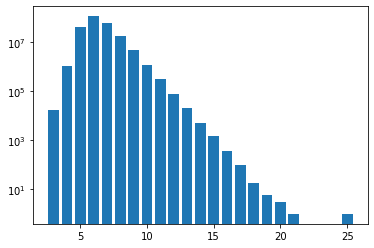

In [42]:
# plt.figure()
plt.bar(*np.unique(err_vals, return_counts=True))
plt.yscale('log')

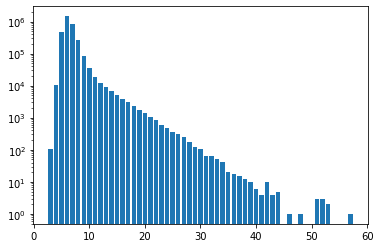

In [43]:
plt.bar(*np.unique(correct_vals, return_counts=True))
plt.yscale('log')

In [45]:
err_all_vals = np.array([all_vals[i] for i in err_idx])
correct_all_vals = np.array([all_vals[i] for i in correct_idx])

In [48]:
all_vals_np = np.array(all_vals)

In [49]:
precs,recs = [],[]
unique_vals = np.unique(vals)
for i in unique_vals:
    over_thresh = np.any(all_vals_np>i, axis=1)
    err_count = np.sum(over_thresh[err_idx])
    correct_count = np.sum(over_thresh[correct_idx])
    recs.append(correct_count/len(correct_idx))
    precs.append(correct_count/(correct_count+err_count))

/tmp/ipykernel_45101/2765815507.py:8: RuntimeWarning: invalid value encountered in long_scalars
  precs.append(correct_count/(correct_count+err_count))


In [52]:
precs[-1] = 0

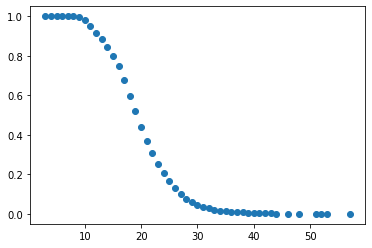

In [54]:
plt.plot(unique_vals, recs, 'o')

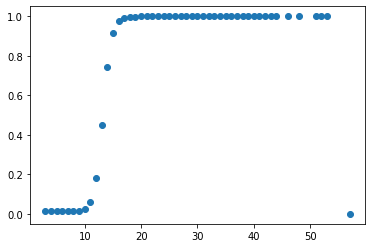

In [55]:
plt.plot(unique_vals, precs, 'o')

In [61]:
y_true = [tuple(j) in gt_tuples for j in pred_df[['i1','i2']].values]
y_score = np.max(all_vals_np, axis=1)

In [59]:
from sklearn.metrics import roc_curve,roc_auc_score

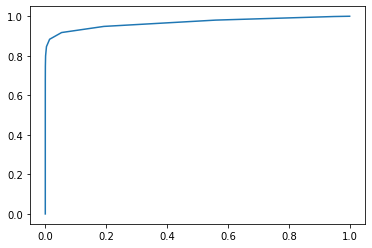

In [62]:
fpr,tpr,thresh = roc_curve(y_true,y_score)
plt.plot(fpr,tpr)
    

In [63]:
roc_auc_score(y_true,y_score)

0.9674867198688478

##  Convert malaria output

In [76]:
aln_path = '/home/gcgreen2/alignment/out/5-17-sh-1-thresh/malaria_sub1.68_ins8.04_del3.16_aln.tsv.bak'
new_path = '/home/gcgreen2/alignment/out/6-16-top/malaria_sub1.68_ins8.04_del3.16_aln.tsv'

In [80]:
with open(aln_path,'r') as fh:
    with open(new_path,'w') as nfh:
        line = fh.readline()
        while line!='':
            fields = line.strip().split()
            arr = literal_eval(fields[-1])
            print(arr, fields)
            break
            new_fields = fields[:5].copy()
            new_fields[2] = max(arr)
            new_line = '\t'.join([new_fields]) + '\n'
            nfh.write(new_line)

SyntaxError: unmatched ']' (<unknown>, line 1)

##  Test suffix hash for LLR

In [89]:
ests = sh.find_overlaps2(fasta_file='/home/gcgreen2/alignment/SequenceAlignmentAndSketching/data/test2/reads.fasta', n_hash=200)


Estimating pairwise overlaps: 100%|███████████████████████████████████| 99/99 [00:02<00:00, 43.19it/s]


In [90]:
ests[:3]

[(1,
  2,
  [9,
   23,
   6,
   57,
   9,
   101,
   7,
   6,
   6,
   5,
   100,
   7,
   8,
   6,
   18,
   96,
   27,
   27,
   6,
   7,
   19,
   6,
   13,
   16,
   6,
   35,
   5,
   53,
   7,
   10,
   23,
   6,
   52,
   21,
   24,
   8,
   15,
   6,
   21,
   6,
   101,
   5,
   7,
   8,
   6,
   38,
   22,
   7,
   6,
   6,
   24,
   47,
   49,
   25,
   18,
   55,
   6,
   20,
   21,
   34,
   6,
   19,
   38,
   7,
   18,
   6,
   28,
   19,
   30,
   50,
   6,
   6,
   21,
   79,
   7,
   27,
   6,
   64,
   5,
   6,
   7,
   29,
   20,
   13,
   19,
   13,
   13,
   53,
   7,
   6,
   38,
   30,
   6,
   13,
   15,
   33,
   11,
   8,
   7,
   6,
   42,
   6,
   71,
   6,
   41,
   6,
   7,
   90,
   6,
   9,
   45,
   6,
   6,
   6,
   53,
   8,
   7,
   16,
   36,
   37,
   6,
   6,
   6,
   16,
   20,
   24,
   29,
   6,
   8,
   47,
   24,
   31,
   16,
   15,
   16,
   5,
   31,
   7,
   8,
   5,
   6,
   10,
   7,
   35,
   57,
   11,
   24,
   27,
   37,
   14,
   

In [93]:
gt_path = '/home/gcgreen2/alignment/SequenceAlignmentAndSketching/data/test2/ground_truth.txt'
gt_df = pd.read_csv(gt_path, sep='\t', header=None, names=['i1','i2','overlap','l1','l2'])
gt_tuples = set([tuple(i) for i in gt_df[['i1','i2']].values])
err_vals = np.concatenate([e[2] for e in ests if tuple(e[:2]) not in gt_tuples])
correct_vals = np.concatenate([e[2] for e in ests if tuple(e[:2]) in gt_tuples])
max_val = max(max(err_vals),max(correct_vals))

In [94]:
max_val

351

In [108]:
min(err_pmf.values())

4.7359696897939855e-06

In [111]:
vals,counts = np.unique(err_vals, return_counts=True)
err_pmf = {v:p/sum(counts) for v,p in zip(vals,counts)}
vals,counts = np.unique(correct_vals, return_counts=True)
corr_pmf = {v:p/sum(counts) for v,p in zip(vals,counts)}
llr = {v:(corr_pmf[v] if v in corr_pmf else 0)/(err_pmf[v] if v in err_pmf else min(err_pmf.values())/100) for v in range(max_val+1)}

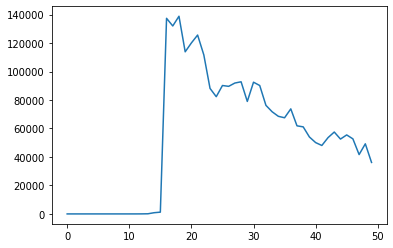

In [113]:
plt.plot([llr[i] for i in range(50)])

In [ ]:
for i in range(len(estimates)):
    statistic = sum([llr[v] for v in estimates[i][2]])
    estimates[i][2] = statistic

return estimates

# #######################################################

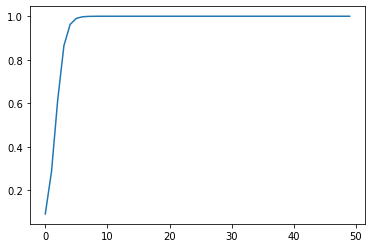

In [121]:
x = np.arange(50, dtype=int)
y = [1/(1+10*4.0**-i) for i in x]
plt.plot(x,y)

In [118]:
4**-4

0.00390625

In [145]:
chroms = su.get_seqs('/home/gcgreen2/alignment/SequenceAlignmentAndSketching/data/malaria/GCA_900632045.1/gen.fna')

In [146]:
len(chroms)

16

In [147]:
len(chroms[0])

1661861

In [149]:
import pandas as pd
import numpy as np
import numpy.random as rnd
import csv
import pickle
import ast
from glob import glob
from io import StringIO
from pathlib import Path
from itertools import product, combinations

MAXK = 8
BASES = {'A','T','C','G'}
BASE_PAIR = {'A':'T', 'T':'A', 'C':'G', 'G':'C'}
kmers_dict = {k:[''.join(kmer) for kmer in product(BASES, repeat=k)] for k in range(1,MAXK+1)}
rev_comp = lambda seq: ''.join([BASE_PAIR[b] for b in seq[::-1]])

def create_kmer_idx_dict(k):
    kmers = kmers_dict[k] 
    kmer_dict = {}
    for i,kmer in enumerate(kmers):
        kmer_dict[kmer] = i
        kmer_dict[i] = kmer
    return kmer_dict
    
kmer_idx_dicts = {k:create_kmer_idx_dict(k) for k in range(1,MAXK+1)}    

def get_dist(seq, k=4, normalize=True):
    kmers = kmers_dict[k]
    kmer_idx_dict = kmer_idx_dicts[k]
    dist = np.zeros(4**k)
    for i in range(len(seq)-k+1):
        kmer = seq[i:i+k]
        dist[kmer_idx_dict[kmer]] += 1
    if normalize:
        return dist / np.sum(dist)
    else:
        return dist

In [153]:
dist = get_dist(chroms[0], k=4)

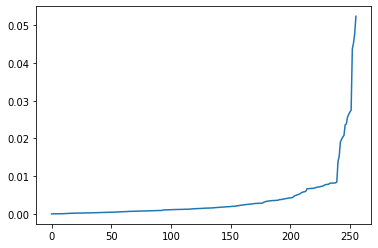

In [154]:
plt.plot(np.sort(dist))